In [1]:
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import time

# Correct images

In this notebook we show how a typhoon sequence can be cleaned. By cleaning we understand mainly two components:
* **Detecting and correcting damaged sequences**: Some frames have corrupted pixels. To solve this, different approaches can be followed.
* **Filling image temporal gaps**: This, however, should always be done within a tolerance range. This means, for instance, that gaps of 20 frames might not be wise to fill as resulting synthetic frames might be very blurry or difuse.

## 1. Create sequence
First, we create a sequence. For this example, let us use sequence `199607`, which contains a remarkable corrupted image frame at position 58. 

In [2]:
from pyphoon.io.typhoonlist import create_typhoonlist_from_source
# Create sequence
sequence = create_typhoonlist_from_source(
    name="199607",
    images="../original_data/image/199607/"
)

Let us check frame 58 and realise that, as aforementioned, it is very well corrupted.

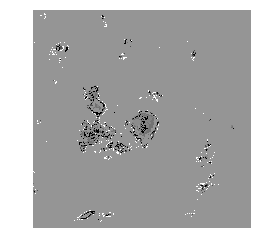

In [3]:
plt.imshow(sequence.get_data('images')[58], cmap="Greys")
plt.axis('off')
plt.show()

Let us check the shape of `typhoon_sequence`, which gives us: shape frame array, shape images ids array, shape best data array, best ids array.

In [4]:
sequence.shape

{'images': (130, 512, 512)}

## 2. Correct corrupted frames

Now time to correct the typhoon list. We achieve this by defining the fixing algorithm through the class `TyphoonListFixAlgorithm` provided by `pyphoon.clean.fix`. In addition, we need to choose which methods we will use to: (i) detect, (ii) correct and, if applicable, (iii) generate synthetic images to fill temporal gaps.

We note the parameter `detect_params`, which provides the detection method with the required parameters. More details on these parameters may be found in the [documentation](http://lcsrg.me/pyphoon/build/html/pyphoon.clean.html#module-pyphoon.clean.detection).

In [5]:
from pyphoon.clean.fix import TyphoonListImageFixAlgorithm
from pyphoon.clean.detection import detect_corrupted_pixels_1
from pyphoon.clean.correction import correct_corrupted_pixels_1

# Define algorithm
fix_algorithm = TyphoonListImageFixAlgorithm(
    detect_fct=detect_corrupted_pixels_1,
    correct_fct=correct_corrupted_pixels_1,
    detect_params={'min_th': 160, 'max_th': 310},
    n_frames_th=2
)

# Apply fixing algorithm
sequence_corrected = fix_algorithm.apply(sequence)

Now, let us check frame 58!

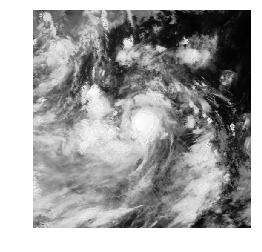

In [6]:
plt.imshow(sequence_corrected.get_data('images')[58], cmap="Greys")
plt.axis('off')
plt.show()

## 3. Fill gaps

Once we have corrected corrupted files, we can define another fixing algorithm to fill temporal gaps. We now add two new arguments to the algorithm object: `fillgaps_fct`, which provides the method by which the new frames will be synthetised and `n_frames_th` which tells the algorithm what is the maximum of consecutive new frames that can be generated.

In [7]:
from pyphoon.clean.fillgaps import generate_new_frames_1

# Define algorithm
fix_algorithm = TyphoonListImageFixAlgorithm(
    detect_fct=detect_corrupted_pixels_1,
    correct_fct=correct_corrupted_pixels_1,
    fillgaps_fct=generate_new_frames_1,
    detect_params={'min_th': 160, 'max_th': 310},
    n_frames_th=3
)

# Apply fixing algorithm
sequence_filled = fix_algorithm.apply(sequence)

After filling the temporal gaps, we should see an increase in the size of the arrays of image frames and image frame ids.

In [8]:
sequence_filled.shape

{'images': (133, 512, 512)}

In addition, `TyphoonListImageFixAlgorithm` has an attribute, i.e. `fixed_ids`, which provides a list of the image frame ids that have been either corrected or generated. Let's see for our example

In [9]:
fix_algorithm.fixed_ids

{'corrected': ['199607_1996072216'],
 'generated': ['199607_1996072304', '199607_1996072404', '199607_1996072504']}

## 4. Display

We now can visualize the sequence after correcting corrupted frames, i.e. `sequence_corrected`.

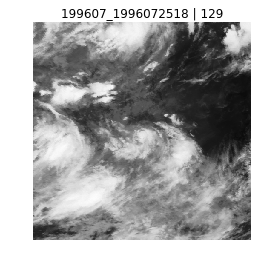

In [10]:
from pyphoon.visualize import DisplaySequence
from IPython.display import HTML

HTML(DisplaySequence(
    typhoon_sequence=sequence_corrected,
    interval=100
).run_html())

And, finally, we visualize the sequence after filling the gaps, i.e. `sequence_filled`.

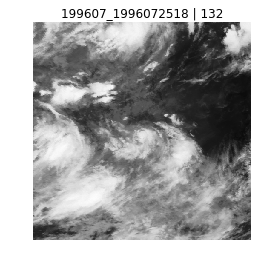

In [11]:
# 'generated': ['199607_1996072304', '199607_1996072404', '199607_1996072504']}
HTML(DisplaySequence(
    typhoon_sequence=sequence_filled,
    interval=100
).run_html())

### Remark
If synthetic image frames have been generated, the size of the new generated file will be considerably larger (in particular approach if first has been done). This is due to the fact that the new generated image contains more different pixel values. It seems that pixel values from original real frames are only allowed to take a certain set of values. Therefore, to mitigate this issue, synthetic image frames should only contain pixel values of that set. Also note that our experiments showed that nearest value brut force search may increase interpolation process by factor of 900. 